In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import datetime
import time
import keras.backend as K
import math

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Bidirectional, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import auc, roc_curve, auc, mean_squared_error
from matplotlib import pyplot as plt
from numpy import concatenate

In [2]:
full_data_path = "/content/drive/MyDrive/datos_web/otros/test3.csv"
ordered_data_path = "/content/drive/MyDrive/datos_web/otros/cleaned_ordered.csv"

ordered_data_path_2 = "/content/drive/MyDrive/datos_web/otros/cleaned_ordered_2.csv"
final_data_path = "/content/drive/MyDrive/datos_web/otros/final_data.csv"

test_clean_data_path = "/content/drive/MyDrive/datos_web/otros/test_clean_data.csv"
test_clean_data_path_2 = "/content/drive/MyDrive/datos_web/otros/test_clean_data_2.csv"
test_clean_data_path_full = "/content/drive/MyDrive/datos_web/otros/test_clean_data_full.csv"


test_cleaned_full_path = "/content/drive/MyDrive/datos_web/otros/full_cleaned.csv"

to_show = "/content/drive/MyDrive/datos_web/otros/to_show.csv"

In [3]:
df = pd.read_csv(full_data_path)
print(df)

          ATA              barrio  carriles  ...  sentido         tipo  velocidad
0         B68         l olivereta         2  ...        2  residencial         30
1         B64         l olivereta         2  ...        2  residencial         30
2         B58          benimaclet         1  ...        1  residencial         30
3         B57           la saidia         1  ...        1  residencial         30
4         B55           benicalap         2  ...        2  residencial         30
...       ...                 ...       ...  ...      ...          ...        ...
4994835  A222           la saidia         2  ...        1    terciaria         30
4994836  A302        ciutat vella         1  ...        1  residencial         30
4994837   B46  poblados maritimos         1  ...        1  residencial         30
4994838   B47  poblados maritimos         1  ...        1  residencial         30
4994839  A229        ciutat vella         1  ...        1  residencial         30

[4994840 rows x

In [4]:
# Combina la fecha y la hora para tener todo en un unico campo
fechas = list(set(df['fecha'].values))
#df['fecha'] = pd.to_datetime(df['fecha'], format="%d/%m/%Y")             # Para el otro fichero
df['fecha'] = pd.to_datetime(df['fecha'], format="%Y-%m-%d")
df['fecha'] = df['fecha'].dt.date
df['hora'] = pd.to_datetime(df['hora'], format="%H:%M:%S")
df['hora'] = df['hora'].dt.time
dates = []
for i in range(len(df['fecha'])):
  combined = datetime.datetime.combine(df['fecha'][i], df['hora'][i])
  dates.append(combined)

df['dates'] = dates
print(dates)
print(fechas)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
fechas.sort()
# Para empezar el 15/03 y acabar el 20/06
fechas = fechas[34:-11]

In [6]:
fechas

['2021-03-15',
 '2021-03-16',
 '2021-03-17',
 '2021-03-18',
 '2021-03-19',
 '2021-03-20',
 '2021-03-21',
 '2021-03-22',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-26',
 '2021-03-27',
 '2021-03-28',
 '2021-03-29',
 '2021-03-30',
 '2021-03-31',
 '2021-04-01',
 '2021-04-02',
 '2021-04-03',
 '2021-04-04',
 '2021-04-05',
 '2021-04-06',
 '2021-04-07',
 '2021-04-08',
 '2021-04-09',
 '2021-04-10',
 '2021-04-11',
 '2021-04-12',
 '2021-04-13',
 '2021-04-14',
 '2021-04-15',
 '2021-04-16',
 '2021-04-17',
 '2021-04-18',
 '2021-04-19',
 '2021-04-20',
 '2021-04-21',
 '2021-04-22',
 '2021-04-23',
 '2021-04-24',
 '2021-04-25',
 '2021-04-26',
 '2021-04-27',
 '2021-04-28',
 '2021-04-29',
 '2021-04-30',
 '2021-05-01',
 '2021-05-02',
 '2021-05-03',
 '2021-05-04',
 '2021-05-05',
 '2021-05-06',
 '2021-05-07',
 '2021-05-08',
 '2021-05-09',
 '2021-05-10',
 '2021-05-11',
 '2021-05-12',
 '2021-05-13',
 '2021-05-14',
 '2021-05-15',
 '2021-05-16',
 '2021-05-17',
 '2021-05-18',
 '2021-05-19',
 '2021-05-

In [7]:
# Pone la columna de coches al final del dataframe
coches = df['coches']
df = df.drop('coches', axis=1)
df.insert(len(df.columns), "coches", coches )
# Ordena por fecha y ATA
df.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
new_df = df.copy()

print(df)

         ATA        barrio  carriles  ... velocidad               dates  coches
330       A1       algiros         8  ...        50 2021-02-03 14:15:00  3660.0
715       A1       algiros         8  ...        50 2021-02-03 15:15:00  4440.0
1101      A1       algiros         8  ...        50 2021-02-03 16:15:00  3756.0
1487      A1       algiros         8  ...        50 2021-02-03 17:15:00  4320.0
1876      A1       algiros         8  ...        50 2021-02-03 18:15:00  2670.0
...      ...           ...       ...  ...       ...                 ...     ...
4992919  B97  ciutat vella         1  ...        30 2021-07-01 09:15:00   209.0
4993307  B97  ciutat vella         1  ...        30 2021-07-01 09:30:00    84.0
4993692  B97  ciutat vella         1  ...        30 2021-07-01 09:45:00   126.0
4994078  B97  ciutat vella         1  ...        30 2021-07-01 10:00:00    84.0
4994462  B97  ciutat vella         1  ...        30 2021-07-01 10:15:00   209.0

[4994840 rows x 15 columns]


In [8]:
data = new_df.copy()
data.set_index(pd.to_datetime(data.dates.values), inplace=True)
data.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
# data = data[data.ATA=="A71"]
# data = data.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
data = data.loc["2021-03-15 00:00:00":"2021-06-30 23:00:00"]
# print(data.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"])
# fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
# ax.set_ylabel("Vehículos/Hora")
# ax = data['coches'].plot(figsize=(26,5))
# x = data.index.values
# y = data['coches'].values
# #some confidence interval
# ci = 1.96 * np.std(y)/np.mean(y)
# print(np.std(y))
# print(np.mean(y))
# plt.fill_between(x, (y-ci), (y+ci), alpha=0.1, linewidth=2, color='r')

In [9]:
show = data[data.ATA=="A71"]

# part1 = show.loc["2021-03-19 00:00:00":"2021-03-22 23:00:00"]
# part2 = show.loc["2021-06-02 00:00:00":"2021-06-09 23:00:00"]

part1 = show.loc["2021-03-15 00:00:00":"2021-05-15 23:00:00"]
part2 = show.loc["2021-05-16 00:00:00":"2021-06-20 23:00:00"]

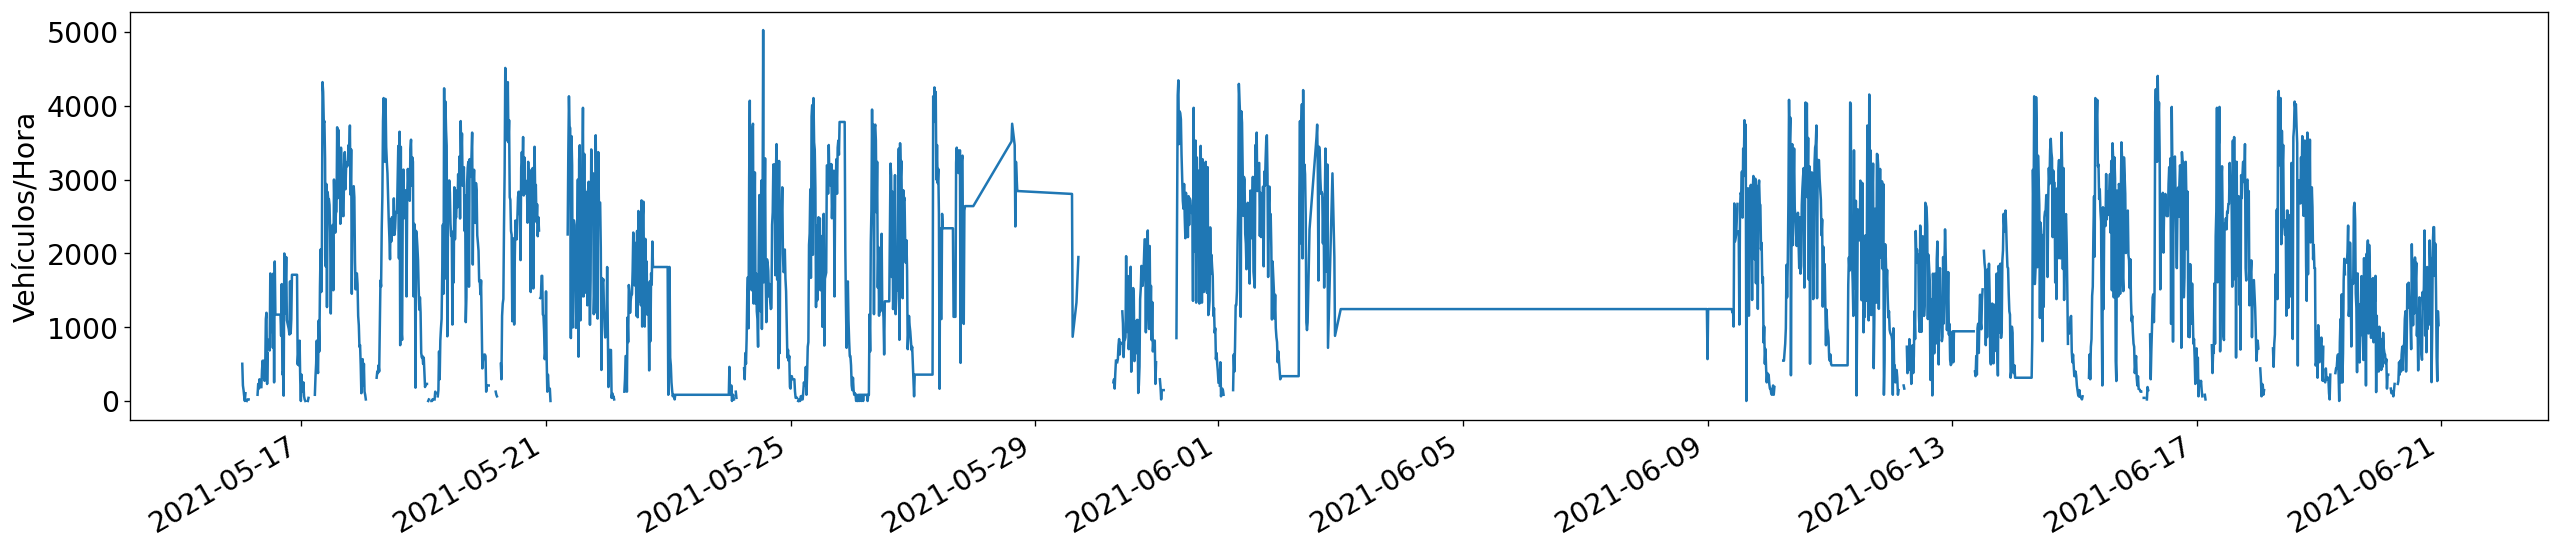

In [10]:
plt.rcParams.update({'font.size': 17}) # must set in top
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
ax.set_ylabel("Vehículos/Hora")
ax = part2['coches'].plot(figsize=(26,5))
# ax.set_ylabel('kw',fontdict={'fontsize':24})
x = part1.index.values
y = part1['coches'].values

In [11]:
def clean_data(data):
  # print(group.loc["2021-03-09"])
  # group.bfill(inplace=True)
  frames = []
  for fecha in fechas:
    elements = group.loc[fecha:fecha]
    # print(elements)
    elements.interpolate(method="linear", inplace=True)
    elements.ffill(inplace=True)
    elements.bfill(inplace=True)
    frames.append(elements)
    # print(elements)
  # print(data.iloc[0:24])
  df = pd.concat(frames)
  # print(group.loc["2021-03-09"])
  return df

In [12]:
indexed = new_df
indexed.set_index(pd.to_datetime(indexed.fecha.values), inplace=True)
data.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
# print(indexed)
# data = indexed["2021-03-09":"2021-06-30"]
# print(data)
groups = indexed.groupby(indexed.ATA)
frames = []

for name, group in groups:
  # if name == "A71":
  group = group.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
  group = clean_data(group)
  # print(group)
  # print(group.iloc[0:24])
  # print(group)
  days = fechas
  # print(days)
  # print(group.get(str(days[0])))
  frames.append(group)

data = pd.concat(frames)
print(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


            ATA        barrio  carriles  ... velocidad               dates coches
2021-03-15   A1       algiros         8  ...        50 2021-03-15 00:00:00    0.0
2021-03-15   A1       algiros         8  ...        50 2021-03-15 00:15:00  402.0
2021-03-15   A1       algiros         8  ...        50 2021-03-15 00:30:00  402.0
2021-03-15   A1       algiros         8  ...        50 2021-03-15 00:45:00  402.0
2021-03-15   A1       algiros         8  ...        50 2021-03-15 01:00:00  402.0
...         ...           ...       ...  ...       ...                 ...    ...
2021-06-20  B97  ciutat vella         1  ...        30 2021-06-20 22:45:00    0.0
2021-06-20  B97  ciutat vella         1  ...        30 2021-06-20 23:00:00    0.0
2021-06-20  B97  ciutat vella         1  ...        30 2021-06-20 23:15:00    0.0
2021-06-20  B97  ciutat vella         1  ...        30 2021-06-20 23:30:00   60.0
2021-06-20  B97  ciutat vella         1  ...        30 2021-06-20 23:45:00    0.0

[3485194 rows x

In [13]:
show = data[data.ATA=="A71"]
show.set_index(pd.to_datetime(show.dates.values), inplace=True)
show.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
# part1 = show.loc["2021-03-19 00:00:00":"2021-03-22 23:00:00"]
# part2 = show.loc["2021-05-20 00:00:00":"2021-05-23 23:00:00"]

part1 = show.loc["2021-03-15 00:00:00":"2021-05-15 23:00:00"]
part2 = show.loc["2021-06-02 00:00:00":"2021-06-10 23:00:00"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


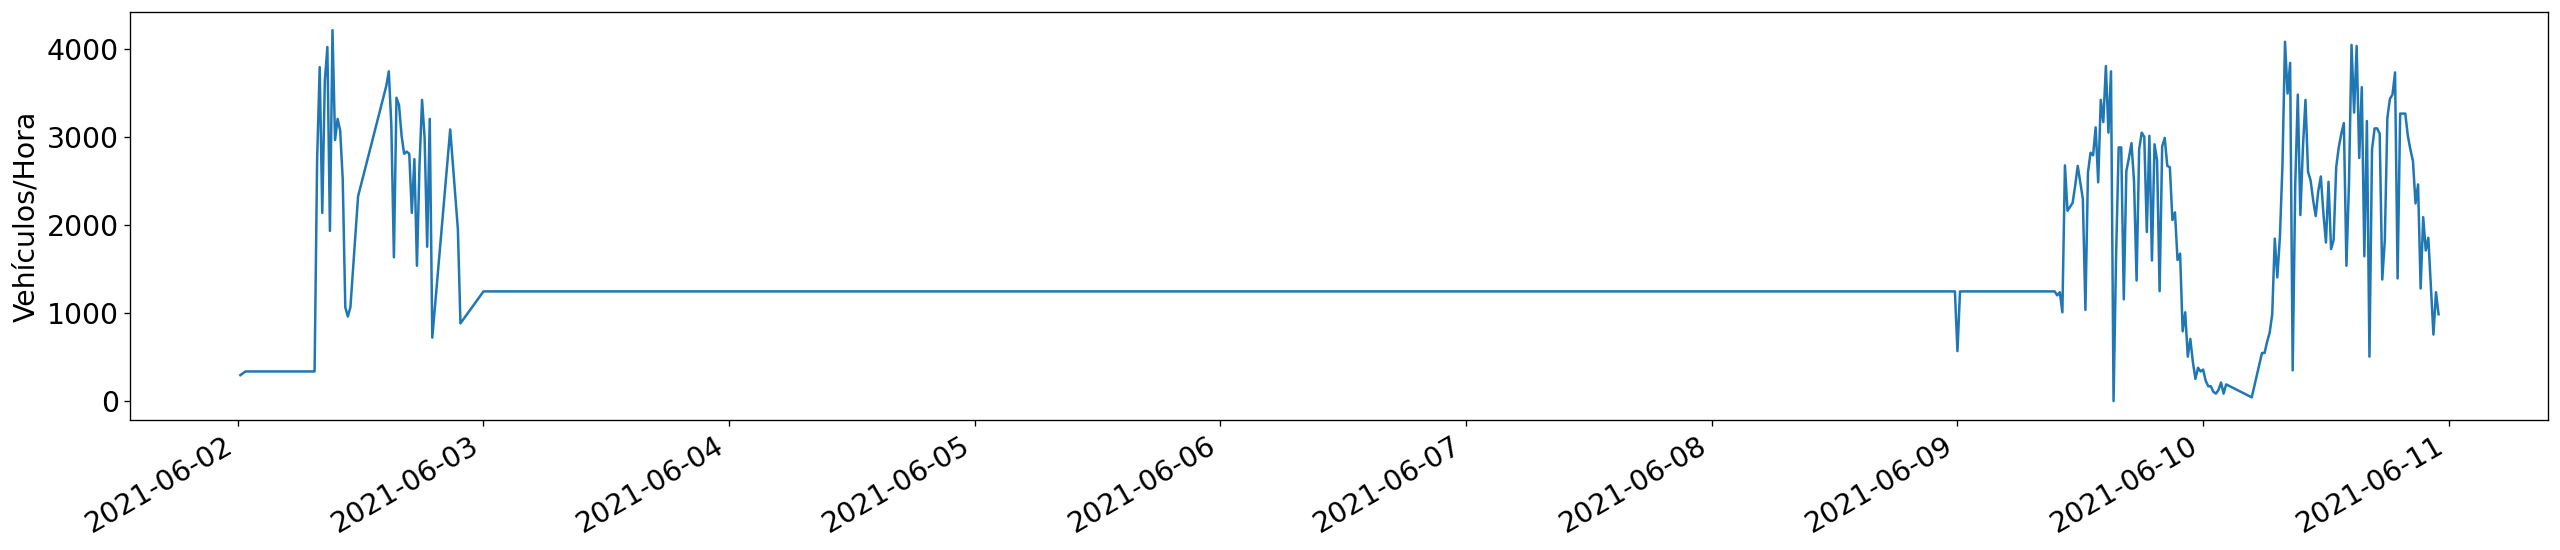

In [14]:
plt.rcParams.update({'font.size': 17}) # must set in top
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
ax.set_ylabel("Vehículos/Hora")
ax = part2['coches'].plot(figsize=(26,5))
x = part2.index.values
y = part2['coches'].values

In [ ]:
# data.set_index(pd.to_datetime(data.dates.values), inplace=True)
# data.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
# # data = data.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
# fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
# ax.set_ylabel("Vehículos/Hora")
# ax = data['coches'].plot(figsize=(26,5))
# x = data.index.values
# y = data['coches'].values

In [15]:
# test_clean_data_path
# Ordena por fecha y ATA
data.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
data.to_csv(test_clean_data_path)
dates_hours = list(set(data.dates.values))

In [16]:
data

,ATA,barrio,carriles,comentario,cp,desc,dia,fecha,festivo,hora,sentido,tipo,velocidad,dates,coches
2021-03-15,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,Lunes,2021-03-15,0,00:00:00,2,entrada,50,2021-03-15 00:00:00,0.0
2021-03-15,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,Lunes,2021-03-15,0,00:15:00,2,entrada,50,2021-03-15 00:15:00,402.0
2021-03-15,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,Lunes,2021-03-15,0,00:30:00,2,entrada,50,2021-03-15 00:30:00,402.0
2021-03-15,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,Lunes,2021-03-15,0,00:45:00,2,entrada,50,2021-03-15 00:45:00,402.0
2021-03-15,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,Lunes,2021-03-15,0,01:00:00,2,entrada,50,2021-03-15 01:00:00,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-20,B97,ciutat vella,1,calle pequeña,46002,sagasta,Domingo,2021-06-20,1,22:45:00,1,residencial,30,2021-06-20 22:45:00,0.0
2021-06-20,B97,ciutat vella,1,calle pequeña,46002,sagasta,Domingo,2021-06-20,1,23:00:00,1,residencial,30,2021-06-20 23:00:00,0.0
2021-06-20,B97,ciutat vella,1,calle pequeña,46002,sagasta,Domingo,2021-06-20,1,23:15:00,1,residencial,30,2021-06-20 23:15:00,0.0
2021-06-20,B97,ciutat vella,1,calle pequeña,46002,sagasta,Domingo,2021-06-20,1,23:30:00,1,residencial,30,2021-06-20 23:30:00,60.0


In [17]:
# Listado de ATAS en el dataset
ATAS = list(set(data['ATA']))
print(len(ATAS))


386


In [18]:
# Transforma los datos 15minutales en datos horarios
def transform_data(df, to_csv):
  # Crea un dataframe diferente por cada ATA
  grouped = df.groupby(df.ATA)
  # Extrae los codigos ATAS sin repeticiones
  # ATAS = list(set(new_df['ATA']))
  # ATAS = ["A52"]
  # Extrae las fechas sin repeticiones
  # fechas = list(set(new_df['fecha']))

  frames = []
  for ATA in ATAS:
    group = grouped.get_group(ATA)
    cars = group['coches']
    # new_group = group.resample('H', on='dates', offset='1Hour').coches.mean()
    new_group = group.resample('H', on='dates', offset='1Hour').coches.mean()
    # new_group.ffill(inplace=True)
    # new_group.fillna(0, inplace=True)
    dates = new_group.keys()
    values = new_group.values
    group = group.drop('coches', axis=1)
    group = group.drop('dia', axis=1)
    group = group.drop('fecha', axis=1)
    group = group.drop('hora', axis=1)
    group = group.drop('dates', axis=1)
    keys = group.keys()
    group = pd.DataFrame(np.resize(group.values, (len(dates), len(group.keys()))))
    for i in range(len(values)):
      if (math.isnan(values[i])):
        values[i] = float("nan")
      else:
        values[i] = int(values[i])
    group['fechas'] = dates    
    # Al juntar por horas, descuadra los dias, volver a poner bien
    group['dia'] = group['fechas'].dt.day_name()
    group['coches'] = values
    for i in range(len(keys)):
      group = group.rename(columns={ i: str(keys[i])})
    frames.append(group)
  result = pd.concat(frames)
  print(result)
  if (to_csv):
    result.to_csv("ordenados.csv")
  return result
data = transform_data(data, True)
# interpolated = transform_data(interpolated, True)
print(data)

       ATA              barrio carriles  ...              fechas     dia coches
0      B88  poblados maritimos        1  ... 2021-03-15 00:00:00  Monday    0.0
1      B88  poblados maritimos        1  ... 2021-03-15 01:00:00  Monday    0.0
2      B88  poblados maritimos        1  ... 2021-03-15 02:00:00  Monday    0.0
3      B88  poblados maritimos        1  ... 2021-03-15 03:00:00  Monday    0.0
4      B88  poblados maritimos        1  ... 2021-03-15 04:00:00  Monday    0.0
...    ...                 ...      ...  ...                 ...     ...    ...
2347  A166          l eixample        5  ... 2021-06-20 19:00:00  Sunday  217.0
2348  A166          l eixample        5  ... 2021-06-20 20:00:00  Sunday  352.0
2349  A166          l eixample        5  ... 2021-06-20 21:00:00  Sunday  330.0
2350  A166          l eixample        5  ... 2021-06-20 22:00:00  Sunday  271.0
2351  A166          l eixample        5  ... 2021-06-20 23:00:00  Sunday  105.0

[907872 rows x 13 columns]
       ATA  

In [ ]:
# data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
# data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)
# test = data
# # test = test.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
# # fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
# ax.set_ylabel("Vehículos/Hora")
# ax = test['coches'].plot(figsize=(26,5))
# x = test.index.values
# y = test['coches'].values

In [19]:
show = data[data.ATA=="A71"]
show.set_index(pd.to_datetime(show.fechas.values), inplace=True)
show.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)

part1 = show.loc["2021-03-15 00:00:00":"2021-05-15 23:00:00"]
part2 = show.loc["2021-05-16 00:00:00":"2021-06-20 23:00:00"]
# part1 = show.loc["2021-03-15 00:00:00":"2021-05-15 23:00:00"]
# part2 = show.loc["2021-06-02 00:00:00":"2021-06-10 23:00:00"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


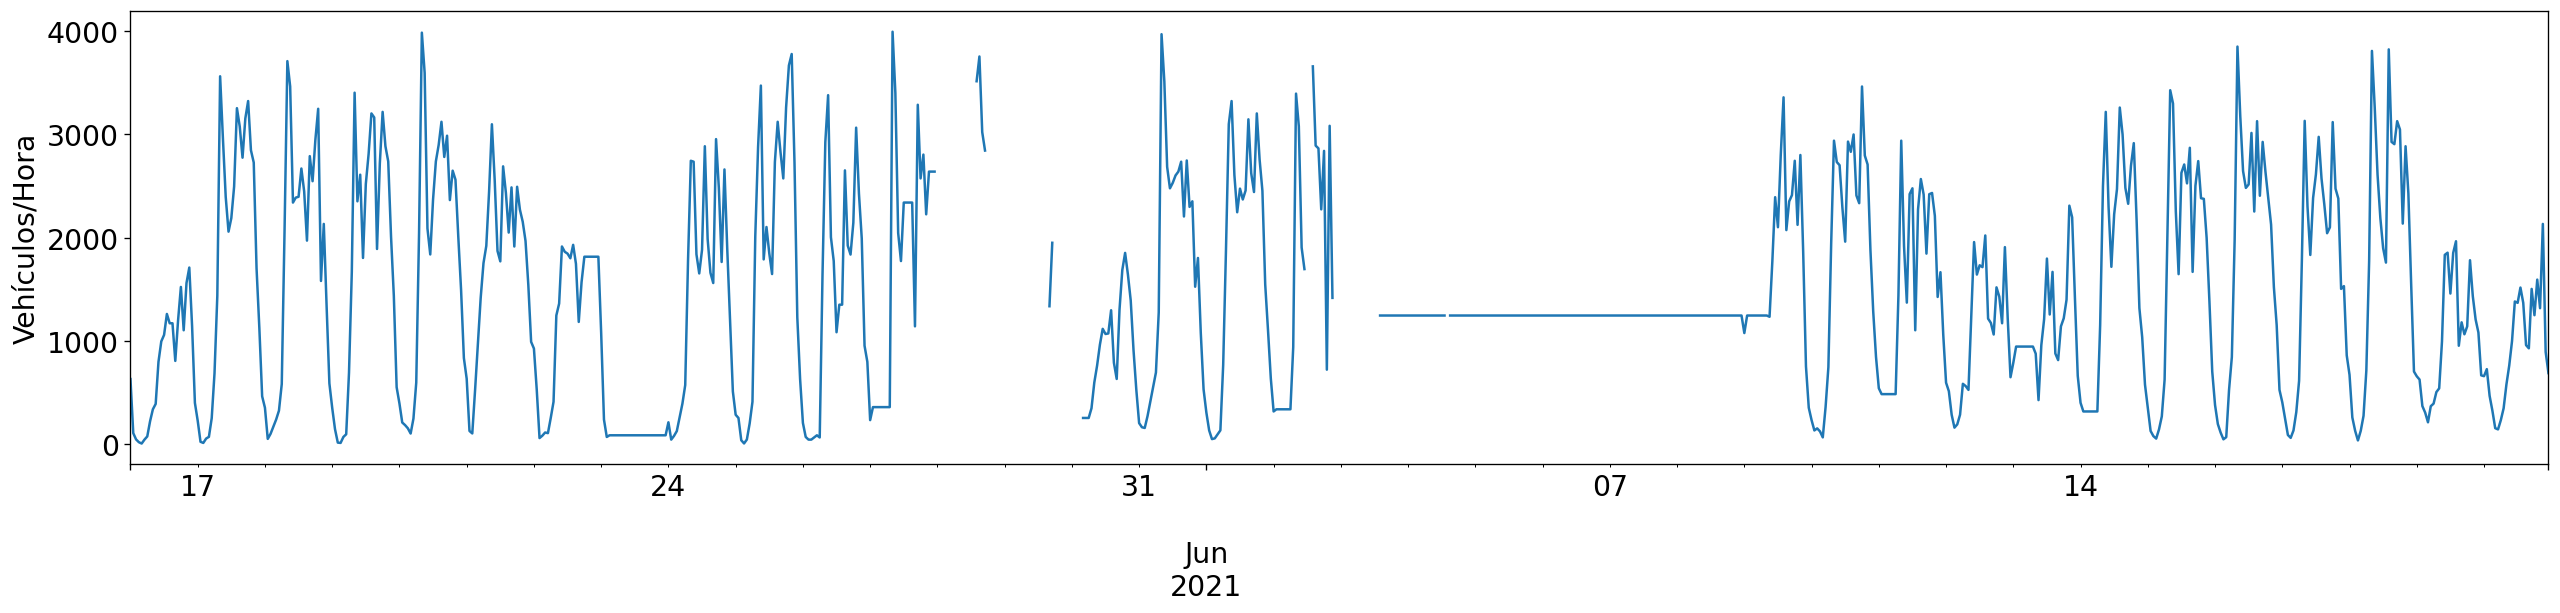

In [20]:
plt.rcParams.update({'font.size': 17}) # must set in top
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
ax.set_ylabel("Vehículos/Hora")
ax = part2['coches'].plot(figsize=(26,5))
x = part2.index.values
y = part2['coches'].values

In [21]:
checkpoint = data

In [26]:
data 
data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)

In [24]:
data

,ATA,barrio,carriles,comentario,cp,desc,festivo,sentido,tipo,velocidad,fechas,dia,coches
0,B88,poblados maritimos,1,calle pequeña,46011,progreso,0,1,residencial,30,2021-03-15 00:00:00,Monday,0.0
1,B88,poblados maritimos,1,calle pequeña,46011,progreso,0,1,residencial,30,2021-03-15 01:00:00,Monday,0.0
2,B88,poblados maritimos,1,calle pequeña,46011,progreso,0,1,residencial,30,2021-03-15 02:00:00,Monday,0.0
3,B88,poblados maritimos,1,calle pequeña,46011,progreso,0,1,residencial,30,2021-03-15 03:00:00,Monday,0.0
4,B88,poblados maritimos,1,calle pequeña,46011,progreso,0,1,residencial,30,2021-03-15 04:00:00,Monday,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,A166,l eixample,5,calle pequeña,46004,navarro reverter,0,2,secundaria,30,2021-06-20 19:00:00,Sunday,217.0
2348,A166,l eixample,5,calle pequeña,46004,navarro reverter,0,2,secundaria,30,2021-06-20 20:00:00,Sunday,352.0
2349,A166,l eixample,5,calle pequeña,46004,navarro reverter,0,2,secundaria,30,2021-06-20 21:00:00,Sunday,330.0
2350,A166,l eixample,5,calle pequeña,46004,navarro reverter,0,2,secundaria,30,2021-06-20 22:00:00,Sunday,271.0


In [ ]:
fechas

In [27]:
groups = data.groupby(data.ATA)
frames = []
# fechas = data.fechas.values
for name, group in groups:
  group = group.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
  # group = group.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
  group = clean_data(group)
  # print(group)
  # print(group.iloc[0:24])
  # print(group)
  days = fechas
  # print(days)
  # print(group.get(str(days[0])))
  frames.append(group)

data = pd.concat(frames)
print(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


                     ATA        barrio  ...     dia coches
2021-03-15 00:00:00   A1       algiros  ...  Monday  301.0
2021-03-15 01:00:00   A1       algiros  ...  Monday  402.0
2021-03-15 02:00:00   A1       algiros  ...  Monday  402.0
2021-03-15 03:00:00   A1       algiros  ...  Monday  402.0
2021-03-15 04:00:00   A1       algiros  ...  Monday  402.0
...                  ...           ...  ...     ...    ...
2021-06-20 19:00:00  B97  ciutat vella  ...  Sunday  104.0
2021-06-20 20:00:00  B97  ciutat vella  ...  Sunday   42.0
2021-06-20 21:00:00  B97  ciutat vella  ...  Sunday   36.0
2021-06-20 22:00:00  B97  ciutat vella  ...  Sunday   10.0
2021-06-20 23:00:00  B97  ciutat vella  ...  Sunday   15.0

[907872 rows x 13 columns]


In [28]:
show = data[data.ATA=="A71"]
show.set_index(pd.to_datetime(show.fechas.values), inplace=True)
show.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)
# part1 = show.loc["2021-03-19 00:00:00":"2021-03-22 23:00:00"]
# part2 = show.loc["2021-05-20 00:00:00":"2021-05-23 23:00:00"]

part1 = show.loc["2021-03-15 00:00:00":"2021-05-15 23:00:00"]
part2 = show.loc["2021-05-16 00:00:00":"2021-06-20 23:00:00"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


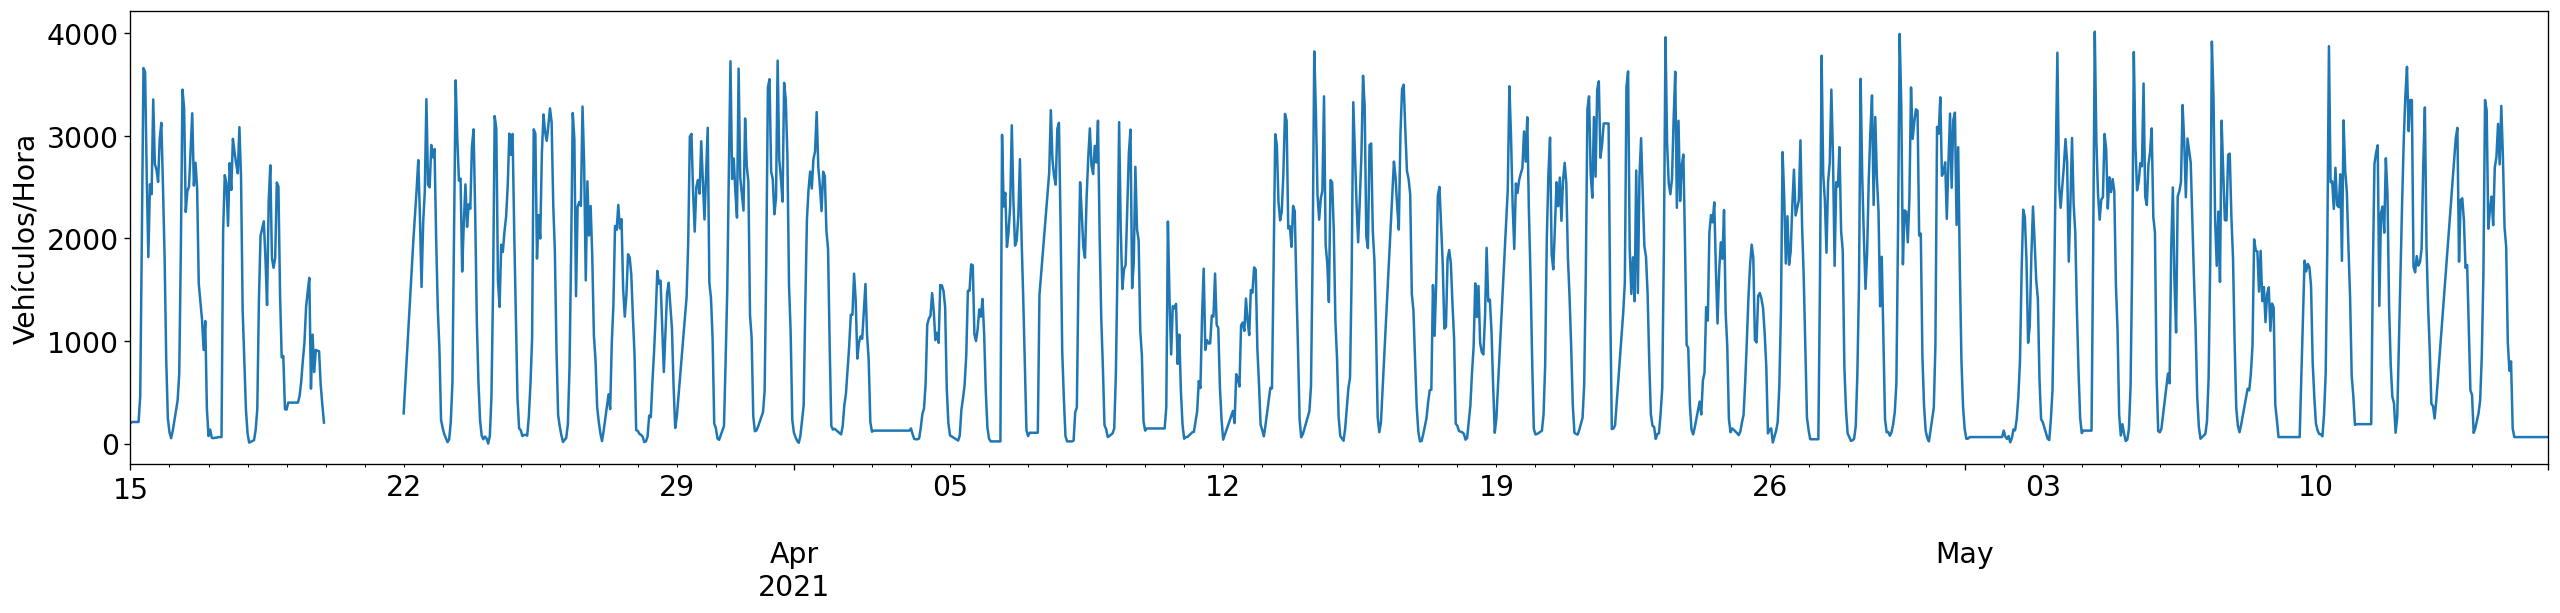

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
ax.set_ylabel("Vehículos/Hora")
ax = part1['coches'].plot(figsize=(26,5))
x = part1.index.values
y = part1['coches'].values

In [30]:
data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)
# # data = data.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
# fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
# ax.set_ylabel("Vehículos/Hora")
# ax = data['coches'].plot(figsize=(26,5))
# x = data.index.values
# y = data['coches'].values

In [31]:
def clean_empty_data(data, fill=False):
  # print(group.loc["2021-03-09"])
  # group.bfill(inplace=True)
  frames = []
  # fechas.sort()
  for i in range(len(fechas)):
    elements = group.loc[fechas[i]:fechas[i]]
    if elements.coches.isna().sum() > 12:
      if elements.ATA.isna().sum() > 0:
        pass
      if (i > 6):
        # print(elements.coches)
        # elements = group[fechas[i-1]:fechas[i-1]]
        coches = frames[i-7].coches
        # print(coches)
        # print(coches)
        # elements = elements.drop('coches', axis=1)
        elements = elements.drop('coches', axis=1)
        # elements["coches"] = cars
        # print(coches)
        # print(elements)
        elements.insert(len(elements.columns), 'coches', coches)
      else:
        # elements = group[fechas[i+7]:fechas[i+7]]
        # print(fechas[i+7])
        coches = group.loc[fechas[i+7]:fechas[i+7]].coches.values
        # print(group[fechas[i+7]:fechas[i+7]])
        elements = elements.drop('coches', axis=1)
        # elements["coches"] = cars
        # print(coches)
        # print(elements)
        elements.insert(len(elements.columns), 'coches', coches)
    frames.append(elements)
  # print(data.iloc[0:24])
  df = pd.concat(frames)
  # print(group.loc["2021-03-09"])
  return df

In [32]:
data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)

In [33]:
groups = data.groupby(data.ATA)
frames = []
# fechas = list(set(data['fechas'].values))
# fechas.sort()
for name, group in groups:
  # group = group.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
  group = group.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
  # print(group)
  group = clean_empty_data(group)
  # print(group)
  days = fechas
  frames.append(group)

data = pd.concat(frames)
# data_cleaned.to_csv(test_clean_data_path_2)
# print(data_cleaned)

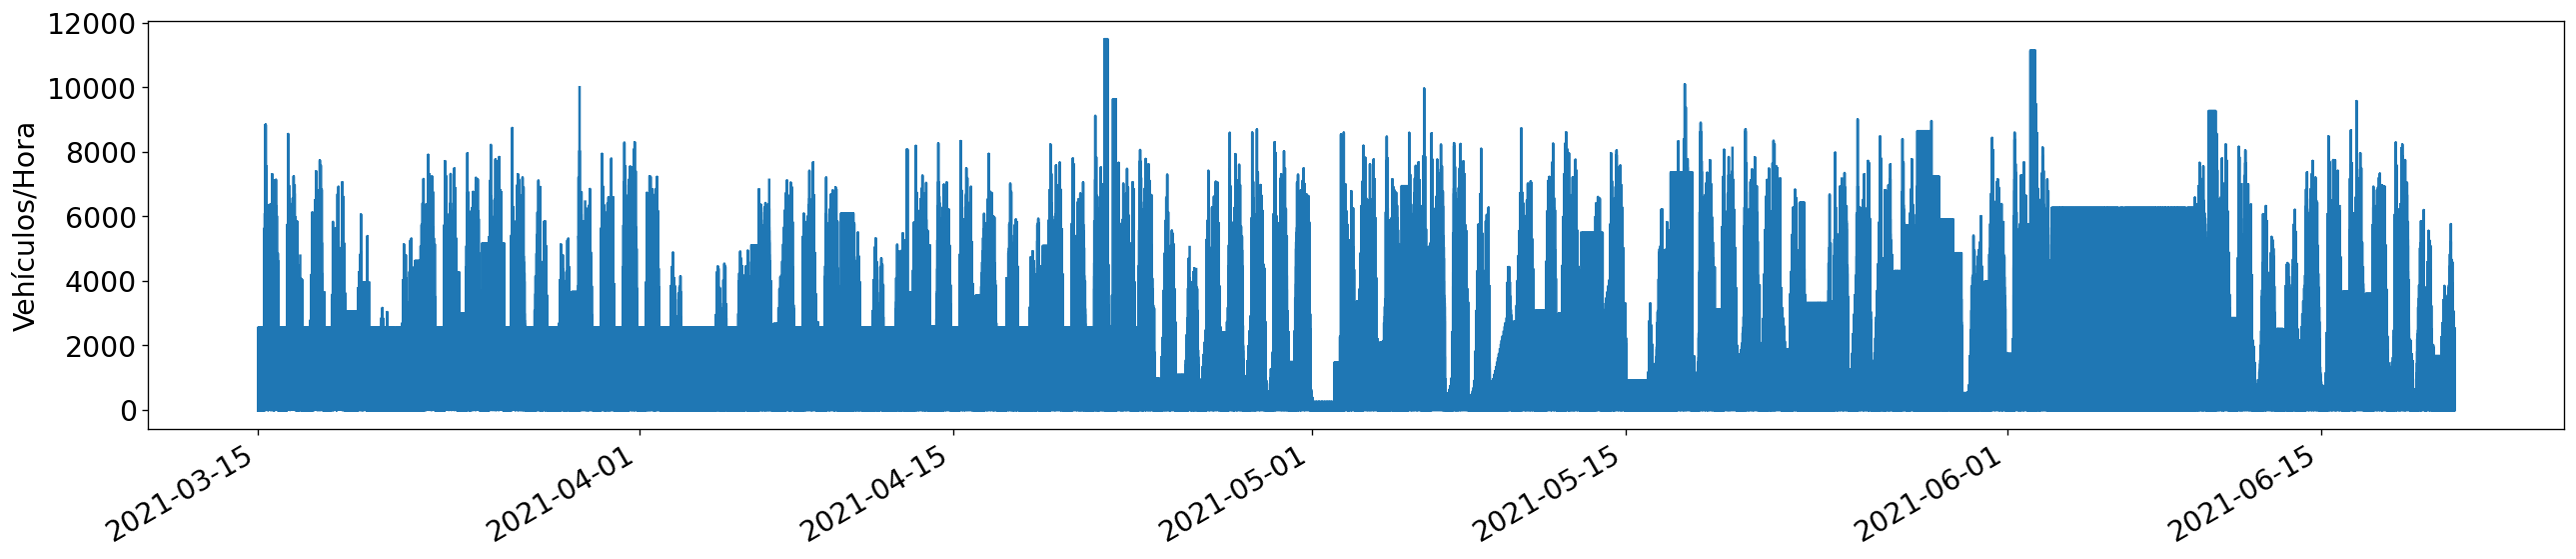

In [35]:
data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)
# data = data.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
ax.set_ylabel("Vehículos/Hora")
ax = data['coches'].plot(figsize=(26,5))
x = data.index.values
y = data['coches'].values

In [36]:
show = data[data.ATA=="A71"]
show.set_index(pd.to_datetime(show.fechas.values), inplace=True)
show.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)
# part1 = show.loc["2021-03-19 00:00:00":"2021-03-22 23:00:00"]
# part2 = show.loc["2021-05-20 00:00:00":"2021-05-23 23:00:00"]

part1 = show.loc["2021-03-15 00:00:00":"2021-05-15 23:00:00"]
part2 = show.loc["2021-05-16 00:00:00":"2021-06-20 23:00:00"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


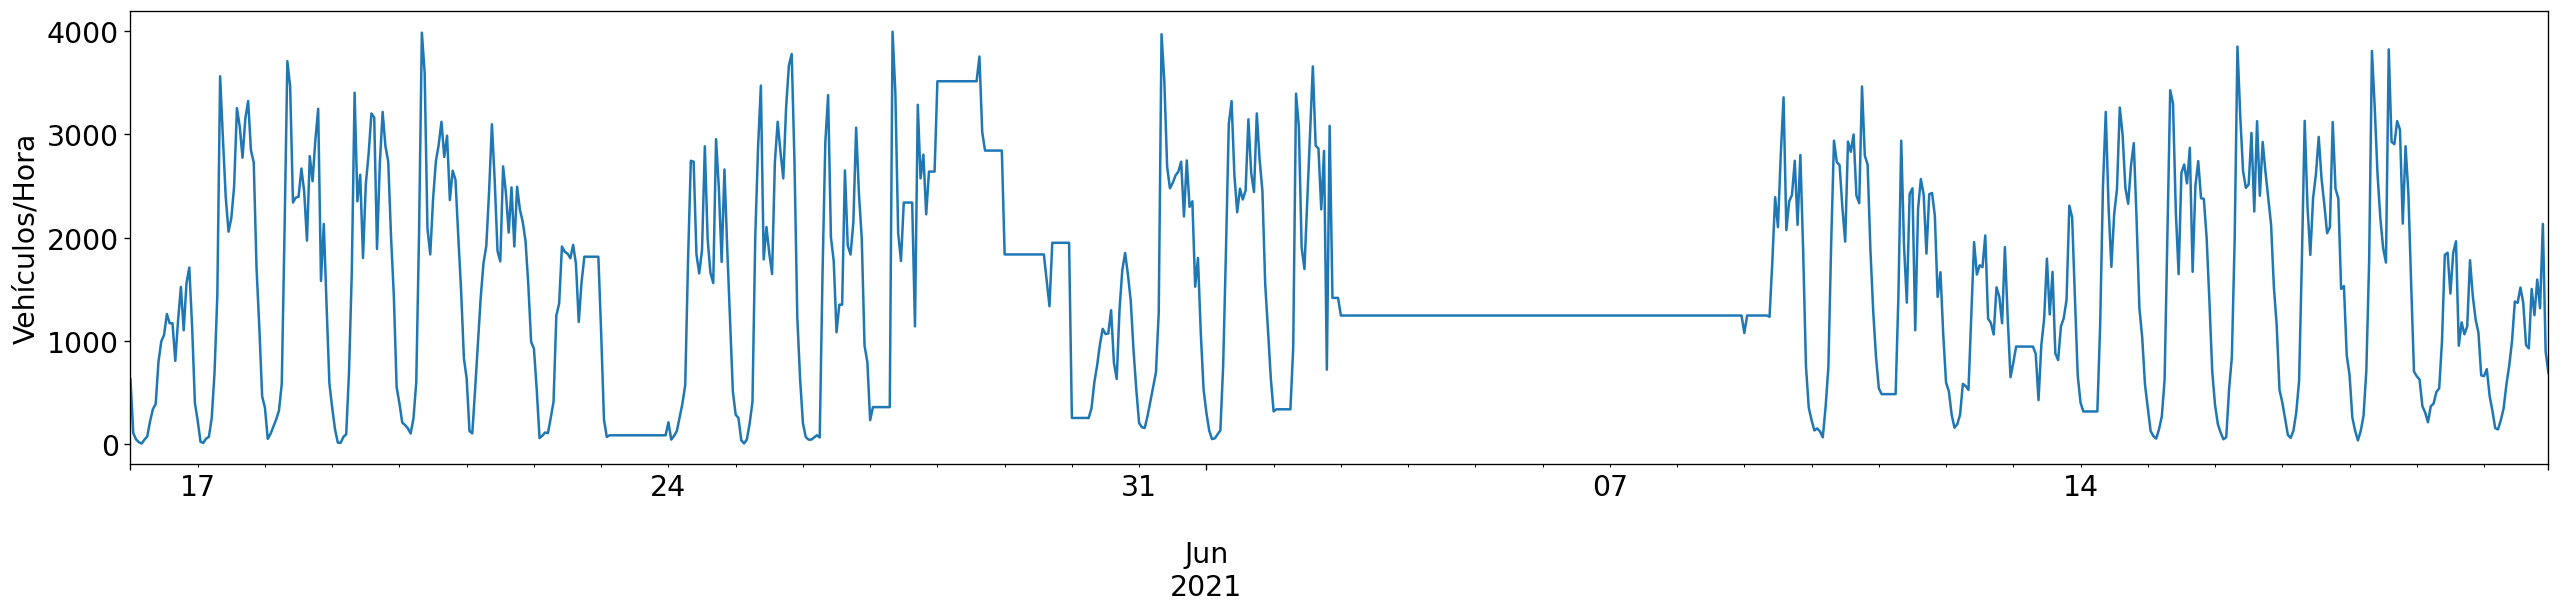

In [37]:
plt.rcParams.update({'font.size': 17}) # must set in top
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
ax.set_ylabel("Vehículos/Hora")
ax = part2['coches'].plot(figsize=(26,5))
x = part2.index.values
y = part2['coches'].values

In [38]:
def clean_repeated_data(data):
  # print(group.loc["2021-03-09"])
  # group.bfill(inplace=True)
  frames = []
  count = 0
  # fechas.sort()
  for i in range(len(fechas)):
    elements = group.loc[fechas[i]:fechas[i]]
    vals = elements.coches.values
    elems = len(list(set((vals))))
    if elems < 5:
      # print(len(list(set((vals)))))
      if (i > 6):
        count += 1
        # print("ANTES", elements)
        prev = frames[i-7]
        cars = prev["coches"].values
        elements.drop("coches", axis=1, inplace=True)
        elements["coches"] = cars
        # print("DESPUES", elements)
      else:
        cars = group.loc[fechas[i+7]:fechas[i+7]].coches.values
        elements.drop("coches", axis=1, inplace=True)
        elements["coches"] = cars
    frames.append(elements)
  # print(data.iloc[0:24])
  df = pd.concat(frames)
  # print("COUNT" ,count)
  # print(group.loc["2021-03-09"])
  return df

data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)
# probando = clean_zero_data(interpolated)
# print(probando)

In [39]:
groups = data.groupby(data.ATA)
frames = []
for name, group in groups:
  # group = group.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
  group = group.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
  # print(group)
  group = clean_repeated_data(group)
  # print(group)
  # print(group.iloc[0:24])
  # print(group)
  days = fechas
  # print(days)
  # print(group.get(str(days[0])))
  frames.append(group)

data = pd.concat(frames)
# data_cleaned.to_csv(test_clean_data_path_2)
print(data)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

                     ATA        barrio  ...     dia coches
2021-03-15 00:00:00   A1       algiros  ...  Monday  301.0
2021-03-15 01:00:00   A1       algiros  ...  Monday  402.0
2021-03-15 02:00:00   A1       algiros  ...  Monday  402.0
2021-03-15 03:00:00   A1       algiros  ...  Monday  402.0
2021-03-15 04:00:00   A1       algiros  ...  Monday  402.0
...                  ...           ...  ...     ...    ...
2021-06-20 19:00:00  B97  ciutat vella  ...  Sunday  104.0
2021-06-20 20:00:00  B97  ciutat vella  ...  Sunday   42.0
2021-06-20 21:00:00  B97  ciutat vella  ...  Sunday   36.0
2021-06-20 22:00:00  B97  ciutat vella  ...  Sunday   10.0
2021-06-20 23:00:00  B97  ciutat vella  ...  Sunday   15.0

[907872 rows x 13 columns]


In [40]:
show = data[data.ATA=="A71"]
show.set_index(pd.to_datetime(show.fechas.values), inplace=True)
show.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)
# part1 = show.loc["2021-03-19 00:00:00":"2021-03-22 23:00:00"]
# part2 = show.loc["2021-05-20 00:00:00":"2021-05-23 23:00:00"]

part1 = show.loc["2021-03-15 00:00:00":"2021-05-15 23:00:00"]
part2 = show.loc["2021-05-16 00:00:00":"2021-06-20 23:00:00"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


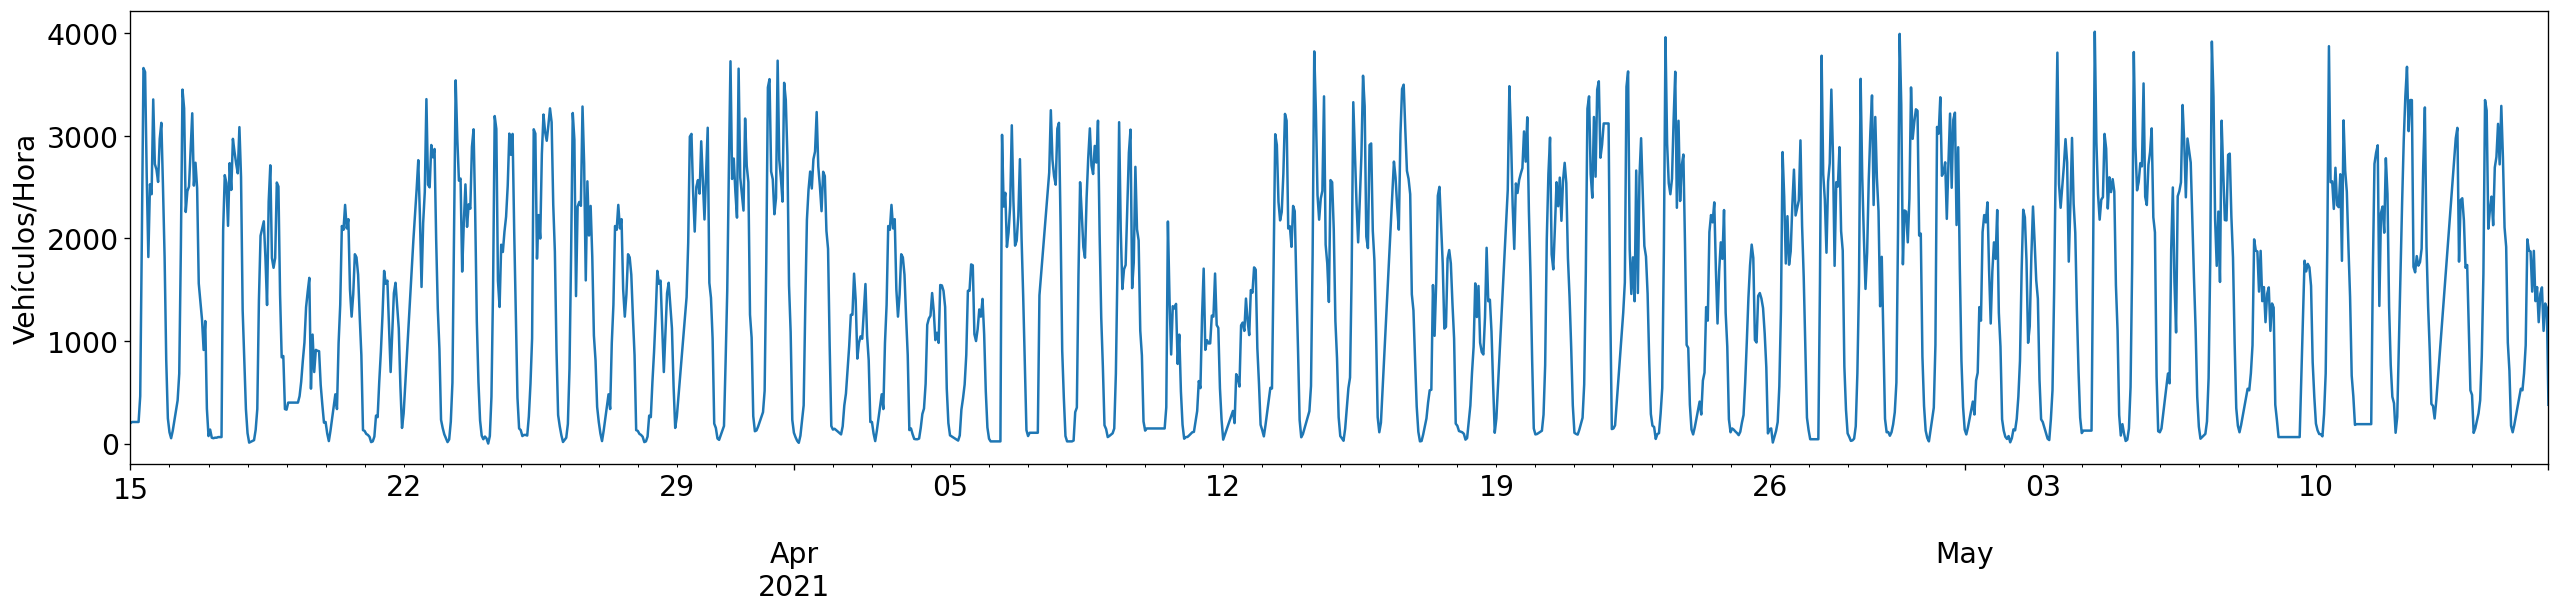

In [41]:
plt.rcParams.update({'font.size': 17}) # must set in top
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
ax.set_ylabel("Vehículos/Hora")
ax = part1['coches'].plot(figsize=(26,5))
x = part1.index.values
y = part1['coches'].values

In [ ]:
test = data[data.ATA=="A71"]
test.coches

2021-03-01 00:00:00      35.0
2021-03-01 01:00:00      31.0
2021-03-01 02:00:00      15.0
2021-03-01 03:00:00      21.0
2021-03-01 04:00:00      84.0
                        ...  
2021-06-30 19:00:00    3081.0
2021-06-30 20:00:00    2559.0
2021-06-30 21:00:00    1170.0
2021-06-30 22:00:00    1622.0
2021-06-30 23:00:00     912.0
Name: coches, Length: 2784, dtype: float64

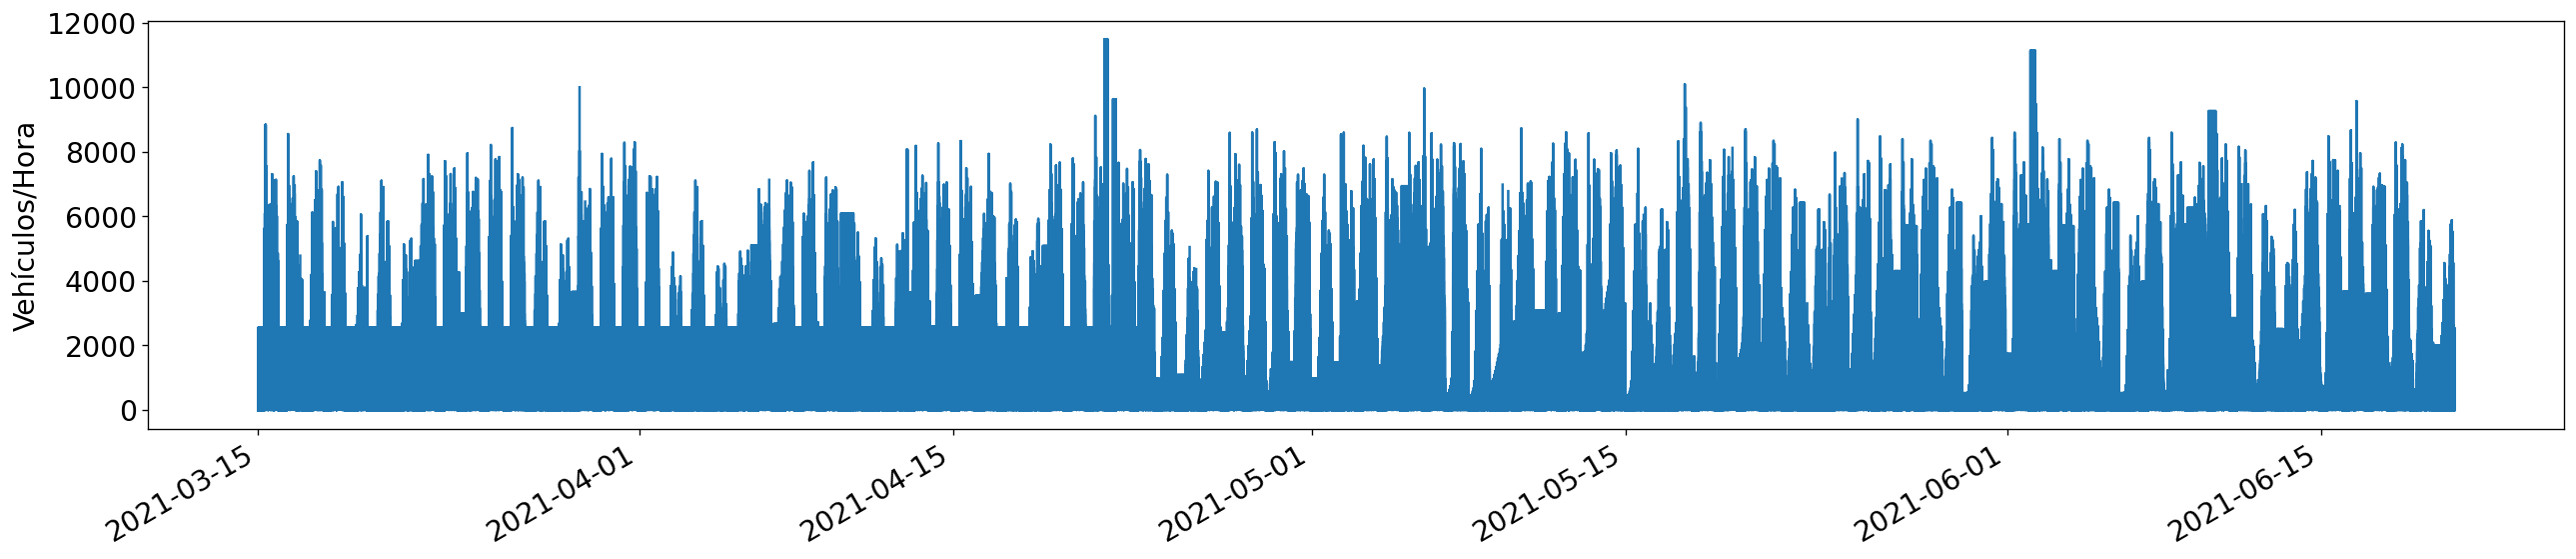

In [42]:
data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)
# data = data[data.ATA=="A71"]
# data = data.loc["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
plt.rcParams.update({'font.size': 17}) # must set in top
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
ax.set_ylabel("Vehículos/Hora")
ax = data['coches'].plot(figsize=(26,5))
x = data.index.values
y = data['coches'].values

In [ ]:
len(ATAS)

386

In [ ]:
data.to_csv(to_show)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data

,ATA,barrio,carriles,comentario,cp,desc,festivo,sentido,tipo,velocidad,fechas,dia,coches
2021-03-15 00:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 00:00:00,Monday,301.0
2021-03-15 01:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 01:00:00,Monday,402.0
2021-03-15 02:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 02:00:00,Monday,402.0
2021-03-15 03:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 03:00:00,Monday,402.0
2021-03-15 04:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 04:00:00,Monday,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,B97,ciutat vella,1,calle pequeña,46002,sagasta,1,1,residencial,30,2021-06-30 19:00:00,Wednesday,261.0
2021-06-30 20:00:00,B97,ciutat vella,1,calle pequeña,46002,sagasta,1,1,residencial,30,2021-06-30 20:00:00,Wednesday,230.0
2021-06-30 21:00:00,B97,ciutat vella,1,calle pequeña,46002,sagasta,1,1,residencial,30,2021-06-30 21:00:00,Wednesday,146.0
2021-06-30 22:00:00,B97,ciutat vella,1,calle pequeña,46002,sagasta,1,1,residencial,30,2021-06-30 22:00:00,Wednesday,21.0


In [ ]:
data.to_csv(ordered_data_path)

In [43]:
ordered = pd.read_csv(to_show)
ordered.drop("Unnamed: 0", axis=1, inplace=True)
print(ordered)

         ATA   barrio  carriles  ...               fechas     dia coches
0         A1  algiros       8.0  ...  2021-03-15 00:00:00  Monday  301.0
1         A1  algiros       8.0  ...  2021-03-15 01:00:00  Monday  402.0
2         A1  algiros       8.0  ...  2021-03-15 02:00:00  Monday  402.0
3         A1  algiros       8.0  ...  2021-03-15 03:00:00  Monday  402.0
4         A1  algiros       8.0  ...  2021-03-15 04:00:00  Monday  402.0
...      ...      ...       ...  ...                  ...     ...    ...
1009771  NaN      NaN       NaN  ...                  NaN     NaN   83.0
1009772  NaN      NaN       NaN  ...                  NaN     NaN  177.0
1009773  NaN      NaN       NaN  ...                  NaN     NaN   73.0
1009774  NaN      NaN       NaN  ...                  NaN     NaN   57.0
1009775  NaN      NaN       NaN  ...                  NaN     NaN   15.0

[1009776 rows x 13 columns]


In [44]:
grouped = ordered.groupby(ordered.ATA)

In [45]:
dates = list(set(list(ordered['fechas'])))
final_df = pd.DataFrame(index=pd.to_datetime(dates))
keys = []
for name, group in grouped:
  # coches = pd.DataFrame(group['coches'].values, index=group['fechas'])
  temp = pd.DataFrame(group['coches'].values, index = pd.to_datetime(group['fechas']))
  # if group["ATA"].iloc[0] == "A52":
  keys.append(group["ATA"].iloc[0])
  final_df = pd.concat([final_df, temp], axis=1)
final_df.sort_index(ascending=True, inplace=True)
final_df.columns = keys


In [ ]:
final_df

,A1,A10,A102,A104,A105,A106,A107,A108,A109,A11,A110,A111,A112,A113,A114,A115,A116,A117,A118,A119,A12,A120,A121,A122,A123,A124,A127,A128,A129,A13,A130,A131,A132,A133,A134,A135,A136,A137,A138,A139,...,B45,B49,B51,B52,B53,B54,B55,B57,B58,B60,B61,B63,B64,B65,B68,B69,B7,B72,B73,B74,B75,B77,B79,B80,B81,B82,B83,B84,B86,B87,B88,B89,B9,B90,B91,B92,B93,B94,B95,B97
2021-03-01,402.0,144.0,36.0,63.0,133.0,42.0,NaN,130.0,84.0,84.0,126.0,126.0,108.0,72.0,42.0,21.0,63.0,NaN,234.0,156.0,0.0,234.0,286.0,263.0,189.0,231.0,84.0,84.0,75.0,NaN,0.0,0.0,0.0,32.0,0.0,84.0,NaN,0.0,105.0,36.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,42.0,NaN,42.0,0.0,0.0,63.0,0.0,42.0,0.0,0.0,0.0,0.0,42.0,21.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2021-03-08,301.0,139.0,27.0,63.0,133.0,42.0,165.0,109.0,84.0,63.0,126.0,136.0,108.0,64.0,31.0,21.0,68.0,159.0,180.0,127.0,10.0,222.0,253.0,226.0,152.0,183.0,63.0,99.0,64.0,26.0,0.0,0.0,0.0,30.0,0.0,63.0,1470.0,0.0,105.0,36.0,...,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,31.0,31.0,11.0,31.0,0.0,0.0,47.0,0.0,31.0,0.0,0.0,0.0,0.0,31.0,21.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,2.0,21.0,0.0
2021-03-09,1108.0,12.0,42.0,160.0,38.0,10.0,0.0,22.0,63.0,0.0,31.0,21.0,0.0,0.0,52.0,0.0,106.0,64.0,105.0,52.0,10.0,42.0,56.0,100.0,63.0,26.0,0.0,15.0,56.0,4.0,0.0,51.0,0.0,8.0,21.0,18.0,0.0,38.0,15.0,31.0,...,7.0,10.0,10.0,0.0,0.0,31.0,0.0,10.0,0.0,29.0,0.0,0.0,52.0,0.0,0.0,0.0,15.0,10.0,10.0,66.0,15.0,0.0,10.0,23.0,0.0,0.0,0.0,31.0,5.0,21.0,0.0,10.0,10.0,10.0,0.0,31.0,0.0,6.0,0.0,0.0
2021-03-10,1196.0,10.0,0.0,126.0,56.0,31.0,0.0,41.0,110.0,0.0,84.0,754.0,0.0,126.0,21.0,0.0,2055.0,166.0,204.0,120.0,31.0,68.0,50.0,187.0,105.0,72.0,10.0,228.0,62.0,0.0,0.0,138.0,15.0,16.0,28.0,31.0,2040.0,31.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,94.0,10.0,31.0,0.0,42.0,0.0,7.0,63.0,0.0,10.0,0.0,0.0,0.0,31.0,152.0,47.0,0.0,0.0,47.0,1.0,0.0,21.0,21.0,15.0,63.0,0.0,0.0,31.0,31.0,0.0,63.0,0.0,17.0,0.0,15.0
2021-03-11,0.0,78.0,10.0,12.0,86.0,0.0,0.0,23.0,84.0,0.0,10.0,52.0,157.0,15.0,31.0,0.0,263.0,169.0,146.0,78.0,52.0,351.0,295.0,177.0,110.0,26.0,21.0,31.0,69.0,10.0,0.0,0.0,10.0,29.0,35.0,31.0,0.0,42.0,0.0,120.0,...,0.0,8.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,10.0,0.0,0.0,3.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,36.0,81.0,36.0,31.0,0.0,0.0,NaN,0.0,15.0,10.0,10.0,52.0,36.0,0.0,10.0,21.0,61.0,54.0,76.0,69.0,0.0,81.0,142.0,106.0,31.0,63.0,63.0,94.0,NaN,47.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,31.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,21.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,10.0,0.0,0.0,10.0,31.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0
2021-06-27,402.0,144.0,36.0,63.0,133.0,42.0,NaN,130.0,84.0,84.0,126.0,126.0,108.0,72.0,42.0,21.0,63.0,NaN,234.0,156.0,0.0,234.0,286.0,263.0,189.0,231.0,84.0,84.0,75.0,NaN,0.0,0.0,0.0,32.0,0.0,84.0,NaN,0.0,105.0,36.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,42.0,NaN,42.0,0.0,0.0,63.0,0.0,42.0,0.0,0.0,0.0,0.0,42.0,21.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2021-06-28,301.0,139.0,27.0,63.0,133.0,42.0,165.0,109.0,84.0,63.0,126.0,136.0,108.0,64.0,31.0,21.0,68.0,159.0,180.0,127.0,10.0,222.0,253.0,226.0,152.0,183.0,63.0,99.0,64.0,26.0,0.0,0.0,0.0,30.0,0.0,63.0,1470.0,0.0,105.0,36.0,...,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,31.0,31.0,11.0,31.0,0.0,0.0,47.0,0.0,31.0,0.0,0.0,0.0,0.0,31.0,21.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,2.0,21.0,0.0
2021-06-29,1108.0,12.0,42.0,160.0,38.0,10.0,0.0,22.0,63.0,0.0,31.0,21.0,0.0,0.0,52.0,0.0,106.0,64.0,105.0,52.0,10.0,42.0,56.0,100.0,63.0,26.0,0.0,15.0,56.0,4.0,0.0,51.0,0.0,8.0,21.0,18.0,0.0

In [ ]:
final_df.to_csv(to_show)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e00d49250>],
      dtype=object)

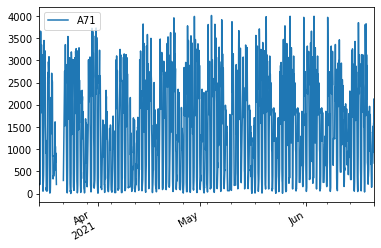

In [ ]:
final_df.plot(subplots=True)

In [ ]:
data = data[data.ATA=="A71"]

In [ ]:
data

,ATA,barrio,carriles,comentario,cp,desc,festivo,sentido,tipo,velocidad,fechas,dia,coches
2021-03-15 00:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 00:00:00,Monday,301.0
2021-03-15 01:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 01:00:00,Monday,402.0
2021-03-15 02:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 02:00:00,Monday,402.0
2021-03-15 03:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 03:00:00,Monday,402.0
2021-03-15 04:00:00,A1,algiros,8,entrada,46021,acceso barcelona entre v-21 y ronda norte,0,2,entrada,50,2021-03-15 04:00:00,Monday,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,83.0
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,177.0
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,73.0
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,57.0
